In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from FeatureStatCalulateFile import FeatureStat

In [2]:
# Preview of the Data: 
# Reading the data into a pandas data frame with defined column names and dropping null values will allow us to achive the processing above
# Define column names
column_names = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
# Read the file, skipping bad lines
data = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', sep=',', names=column_names, on_bad_lines='skip')
# drop null values: 
data = data.dropna()

data['z-axis'] = data['z-axis'].str.rstrip(';').astype(float)

In [29]:
df_8 = data[data['user'] == 32]

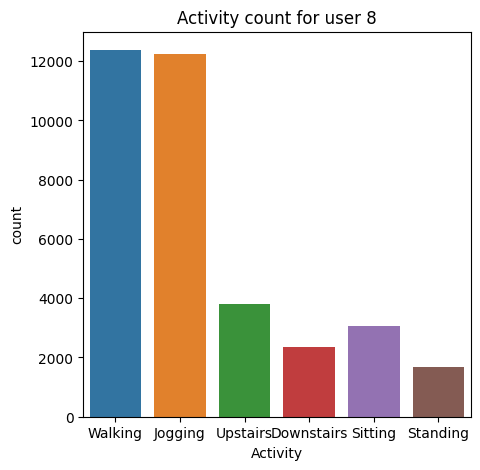

In [30]:
plt.figure(figsize=(5,5))
sns.countplot(x='activity', data=df_8, hue='activity')
plt.xlabel('Activity')
plt.title('Activity count for user 8')
plt.show()

In [31]:
# create window sizes: 

def get_windows(df, window_size, step_size):

    x_list = []
    y_list = []
    z_list = []
    activity_list = []
    for i in range(0, df.shape[0] - window_size, step_size):
        xs = df['x-axis'].values[i : i + window_size]
        ys = df['y-axis'].values[i : i + window_size]
        zs = df['z-axis'].values[i : i + window_size]
        label = df['activity'][i : i + window_size].mode()[0]

        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        activity_list.append(label)
    return x_list, y_list, z_list, activity_list

In [32]:
X = pd.DataFrame()

In [33]:
x_list, y_list, z_list, activity_list = get_windows(df_8, 100, 50)

In [34]:
featured_data = FeatureStat(X, x_list, y_list, z_list)

In [35]:
X = featured_data.all()

In [36]:
from sklearn.model_selection import train_test_split

In [38]:
y = pd.Series(activity_list)  # Corresponding labels

# Step 3: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Verify the splits
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (567, 59) (567,)
Test set shape: (142, 59) (142,)


In [39]:
scaler = StandardScaler()
X_train  = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [41]:
# Decision Tree with Cross-Validation
decisionTree = DecisionTreeClassifier(random_state=529)
cv_scores_dt = cross_val_score(decisionTree, X_train, y_train, cv=skf, scoring='accuracy')
decisionTree.fit(X_train, y_train)
dT_yPred = decisionTree.predict(X_test)
dT_accuracy = accuracy_score(y_test, dT_yPred)

print(f"Decision Tree Accuracy on test set: {dT_accuracy * 100:.2f}%")
print("Decision Tree Cross-Validation Scores:", cv_scores_dt)
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores_dt) * 100:.2f}%")
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, dT_yPred))

Decision Tree Accuracy on test set: 97.89%
Decision Tree Cross-Validation Scores: [0.92982456 0.94736842 0.95575221 0.98230088 0.97345133]
Mean Cross-Validation Accuracy: 95.77%

Decision Tree Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.89      0.89      0.89         9
     Jogging       1.00      0.98      0.99        49
     Sitting       1.00      1.00      1.00        12
    Standing       1.00      1.00      1.00         7
    Upstairs       0.93      0.93      0.93        15
     Walking       0.98      1.00      0.99        50

    accuracy                           0.98       142
   macro avg       0.97      0.97      0.97       142
weighted avg       0.98      0.98      0.98       142



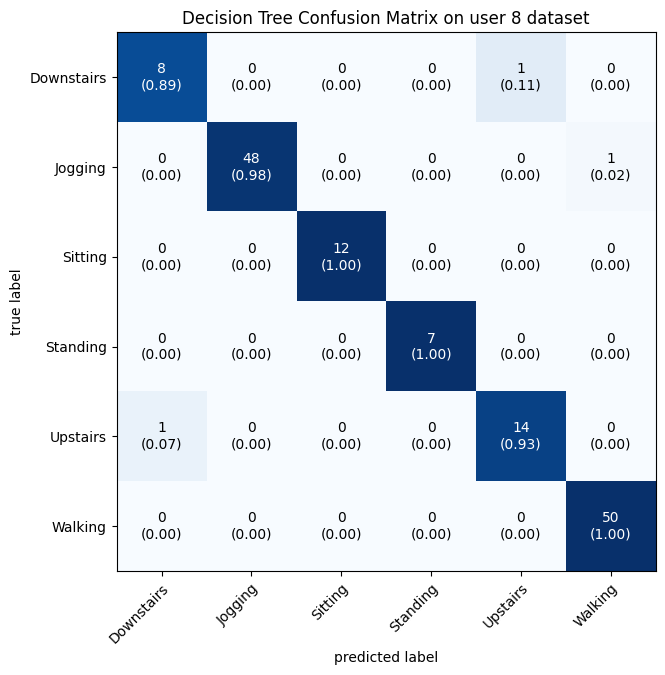

In [42]:
dT_cm = confusion_matrix(y_test, dT_yPred)
plot_confusion_matrix(dT_cm, class_names=decisionTree.classes_, show_normed=True, figsize=(7,7))
plt.title("Decision Tree Confusion Matrix on user 8 dataset")
plt.show()

In [43]:
# Random Forest with Cross-Validation
randomForest = RandomForestClassifier(random_state=400)
cv_scores_rf = cross_val_score(randomForest, X_train, y_train, cv=skf, scoring='accuracy')
randomForest.fit(X_train, y_train)
rF_yPred = randomForest.predict(X_test)
rF_accuracy = accuracy_score(y_test, rF_yPred)

print(f"Random Forest Accuracy on test set: {rF_accuracy * 100:.2f}%")
print("Random Forest Cross-Validation Scores:", cv_scores_rf)
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores_rf) * 100:.2f}%")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rF_yPred))


Random Forest Accuracy on test set: 98.59%
Random Forest Cross-Validation Scores: [0.99122807 0.98245614 0.96460177 1.         0.99115044]
Mean Cross-Validation Accuracy: 98.59%

Random Forest Classification Report:
              precision    recall  f1-score   support

  Downstairs       1.00      0.89      0.94         9
     Jogging       1.00      0.98      0.99        49
     Sitting       1.00      1.00      1.00        12
    Standing       1.00      1.00      1.00         7
    Upstairs       0.94      1.00      0.97        15
     Walking       0.98      1.00      0.99        50

    accuracy                           0.99       142
   macro avg       0.99      0.98      0.98       142
weighted avg       0.99      0.99      0.99       142



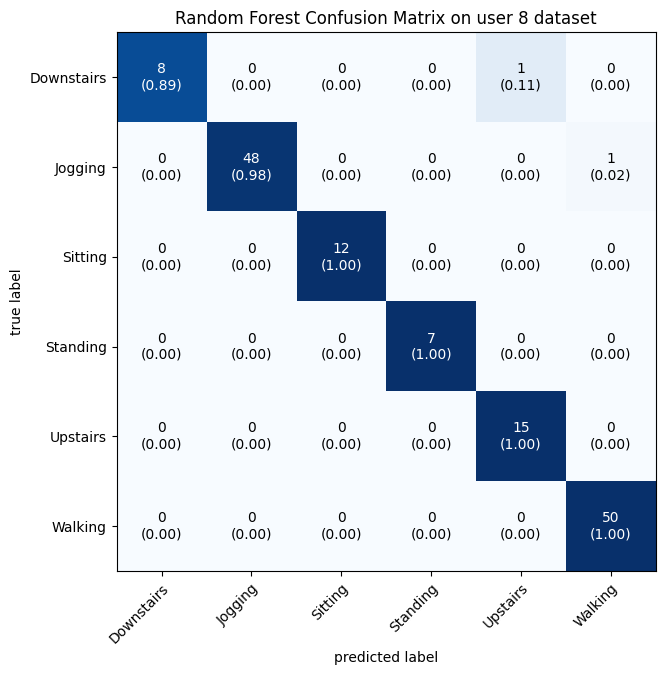

In [44]:
rF_cm = confusion_matrix(y_test, rF_yPred)
plot_confusion_matrix(rF_cm, class_names=decisionTree.classes_, show_normed=True, figsize=(7,7))
plt.title("Random Forest Confusion Matrix on user 8 dataset")
plt.show()